# API

In [2]:
import numpy as np
import scipy.sparse as sp
import scipy.sparse.linalg as sla
import scipy.linalg as la
import scipy.stats
import matplotlib.pyplot as plt
import time
import pickle
from copy import copy
# %load_ext line_profiler

In [3]:
plt.rcParams['text.usetex']=True
plt.rcParams['font.family']='serif'
plt.rcParams['font.size']=9
plt.rcParams['axes.titlesize']=plt.rcParams['font.size']
plt.rcParams['figure.figsize']=(6.8,4)

In [4]:
# ipcluster start --engines=MPI -n 4
import ipyparallel as ipp
rc = ipp.Client()
rc[:].execute("from Chern_insulator import *")
rc[:].execute("import numpy as np")

<AsyncResult: execute>

In [20]:
# %%writefile Chern_insulator.py
import numpy as np
import scipy.linalg as la
import numpy.linalg as nla
import numpy.matlib


class Params:
    def __init__(self,
            Lx=4,
            Ly=16,
            t=1,
            Delta=1,
            m=1,
            bcx=1,
            bcy=-1,
            T=0,
            dxmax=16,
            dymax=16,
            history=False,
            ):
        self.Lx = Lx
        self.Ly = Ly
        self.t = t
        self.Delta = Delta
        self.m = m
        self.bcx = bcx
        self.bcy = bcy
        self.T = T
        self.history = history
        self.sigmax = np.array([[0, 1], [1, 0]])
        self.sigmay = np.array([[0, -1j], [1j, 0]])
        self.sigmaz = np.array([[1, 0], [0, -1]])
        # check which one is faster, use sparse or dense?
        if Lx<np.inf and Ly<np.inf:
            hopx = np.diag(np.ones(Lx-1), -1)
            hopx[0, -1] = bcx
            hopy = np.diag(np.ones(Ly-1), -1)
            hopy[0, -1] = bcy
            hopxmat = np.kron(hopx, np.eye(Ly))
            hopymat = np.kron(np.eye(Lx), hopy)
            onsitemat = np.eye(Lx*Ly)
            self.Hamiltonian = ((np.kron(hopxmat-hopxmat.T, self.sigmax)+np.kron(hopymat-hopymat.T, self.sigmay))* 1j*t-Delta*np.kron(hopxmat+hopxmat.T+hopymat+hopymat.T, self.sigmaz))/2+m*np.kron(onsitemat, self.sigmaz)
        elif Lx==np.inf and Ly==np.inf:
            self.dxmax=dxmax
            self.dymax=dymax
            self.dx=lambda kx: t*np.sin(kx)
            self.dy=lambda ky: t*np.sin(ky)
            self.dz=lambda kx,ky: m-Delta*np.cos(kx)-Delta*np.cos(ky)
        else:
            raise ValueError('The size of system {:d,:d} is not supported.'.format(Lx,Ly))
            

    def bandstructure(self):
        val, vec = nla.eigh(self.Hamiltonian)
        sortindex = np.argsort(val)
        self.val = val[sortindex]
        self.vec = vec[:, sortindex]


    # def E_k(self,kx,ky,branch):
    #     '''
    #     branch = +/-1
    #     '''
    #     return branch*np.sqrt(self.dx(kx)**2+self.dy(ky)**2+self.dz(k)**2)
    #     # return branch*np.sqrt(self.t**2*(np.sin(kx)**2+np.sin(ky)**2)+(self.m-self.Delta*np.cos(kx)-self.Delta*np.cos(ky))**2)

    def fermi_dist_k(self,kx,ky,branch,E_F=0):
        if self.T==0:
            return np.heaviside(E_F-self.E_k(kx,ky,branch),0)
        else:
            return 1/(1+np.exp((self.E_k(kx,ky,branch)-E_F)/self.T))

    def fermi_dist(self, energy, E_F):
        if self.T == 0:
            return np.heaviside(E_F-energy, 0)
        else:
            return 1/(1+np.exp((energy-E_F)/self.T))

    def correlation_matrix_inf_fft(self,threshold=[1024,512]):
        '''
        self.dxmax/self.dymax: the maximal distance in x/y direction (in terms of unit cell) 
        Directly call fft to evaluate the integral
        '''
        assert self.Lx==np.inf and self.Ly==np.inf, "Wire length should be inf"
        # cov_mat=[]
        Nxmax=max(2*self.dxmax,threshold[0])
        Nymax=max(2*self.dymax,threshold[1])
        if self.T>0:
            pass    #to be filled
        else:
            kxlist=np.arange(0,2*np.pi,2*np.pi/Nxmax)
            kylist=np.arange(0,2*np.pi,2*np.pi/Nymax)
            kxmap,kymap=np.meshgrid(kxlist,kylist)
            dxmap=self.dx(kxmap)
            dymap=self.dy(kymap)
            dzmap=self.dz(kxmap,kymap)
            Ekmap=np.sqrt(dxmap**2+dymap**2+dzmap**2)
            Ekxymap=np.sqrt(dxmap**2+dymap**2)
            costheta=dzmap/Ekmap
            sintheta=Ekxymap/Ekmap
            Ekxymap[0,0]=np.inf #to avoid 0/0 in cos(phi) & sin(phi); the order of this line matters
            cosphi=dxmap/Ekxymap
            sinphi=dymap/Ekxymap
            fftcostheta=np.fft.ifft2(costheta)
            constmap=np.zeros((Nymax,Nxmax))
            constmap[0,0]=0.5
            A_11=constmap-fftcostheta/2
            A_22=constmap+fftcostheta/2
            A_12=np.fft.ifft2(-(cosphi-1j*sinphi)/2*sintheta)
            A_21=np.fft.ifft2(-(cosphi+1j*sinphi)/2*sintheta)
            mat=np.stack([[A_11,A_12],[A_21,A_22]])
            C_f=np.zeros((2*self.dxmax*self.dymax,2*self.dxmax*self.dymax))*1j
            for i in range(self.dxmax*self.dymax):
                for j in range(i):
                    di,dj=(i-j)%self.dymax,(i-j)//self.dymax
                    C_f[2*i:2*i+2,2*j:2*j+2]=mat[:,:,di,dj]
            C_f=C_f+C_f.T.conj()
            for i in range(self.dxmax*self.dymax):
                C_f[2*i:2*i+2,2*i:2*i+2]=mat[:,:,0,0]
            self.C_f=C_f

    def correlation_matrix(self, E_F=0):
        '''
        G_{ij}=<f_i^\dagger f_j>
        '''
        if not (hasattr(self, 'val') and hasattr(self, 'vec')):
            self.bandstructure()
        occupancy_mat = np.matlib.repmat(
            self.fermi_dist(self.val, E_F), self.vec.shape[0], 1)
        self.C_f = ((occupancy_mat*self.vec)@self.vec.T.conj())

    def covariance_matrix(self, E_F=0):
        '''
        c.f. notes
        Maybe differs by a minus sign
        '''
        if not hasattr(self, 'C_f'):
            if self.Lx < np.inf and self.Ly<np.inf:
                self.correlation_matrix()
            else:
                self.correlation_matrix_inf_fft()
        G = self.C_f
        Gamma_11 = 1j*(G-G.T)
        Gamma_21 = -(np.eye(G.shape[0])-G-G.T)
        Gamma_12 = -Gamma_21.T
        Gamma_22 = -1j*(G.T-G)
        Gamma = np.zeros((2*G.shape[0], 2*G.shape[0]), dtype=complex)
        even = np.arange(2*G.shape[0])[::2]
        odd = np.arange(2*G.shape[0])[1::2]
        Gamma[np.ix_(even, even)] = Gamma_11
        Gamma[np.ix_(even, odd)] = Gamma_12
        Gamma[np.ix_(odd, even)] = Gamma_21
        Gamma[np.ix_(odd, odd)] = Gamma_22
        assert np.abs(np.imag(Gamma)).max() < 1e-10, "Covariance matrix not real {:.5f}".format(np.abs(np.imag(Gamma)).max())
        self.C_m = np.real(Gamma-Gamma.T.conj())/2
        self.C_m_history = [self.C_m]

    def linearize_index(self, subregion, n, proj=False):
        '''
        If proj ==True, then the index used for projection operator will be returned
        '''
        subregion_x, subregion_y = (subregion)
        subregion_x = np.array(subregion_x)
        subregion_y = np.array(subregion_y)
        X, Y = np.meshgrid(subregion_x, subregion_y)
        if self.Ly<np.inf:
            linear_index = ((X*self.Ly+Y).flatten('F'))
        else:
            linear_index = ((X*self.dymax+Y).flatten('F'))
        if proj:
            return sorted(np.concatenate([n*linear_index+i for i in range(0, n, 2)]))
        else:
            return sorted(np.concatenate([n*linear_index+i for i in range(n)]))

    def c_subregion_f(self, subregion, linear=True):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_f'):
            self.correlation_matrix()
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 2)
        # This is a dumb way...
        return self.C_f[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_f(self, subregion):
        c_A = self.c_subregion_f(subregion)
        val = nla.eigvalsh(c_A)
        self.val_sh = val
        val = np.sort(val)
        return np.real(-np.sum(val*np.log(val+1e-18j))-np.sum((1-val)*np.log(1-val+1e-18j)))

    def c_subregion_m(self, subregion, Gamma=None):
        '''
        subregion: [subregoin_x, subregion_y] index of unit cell
        '''
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if Gamma is None:
            Gamma = self.C_m_history[-1]
        try:
            subregion = list(subregion)
        except:
            raise ValueError("The subregion is ill-defined"+subregion)

        if len(subregion) == 2:
            if isinstance(subregion[0], int) and isinstance(subregion[1], int):
                linear = True
            elif (not isinstance(subregion[0], int)) and (not isinstance(subregion[1], int)):
                linear = False
            else:
                raise ValueError('Illegal subregion')
        else:
            linear = True
        if linear:
            # linearized index
            subregion_index = subregion
        else:
            # 2D index
            subregion_index = self.linearize_index(subregion, 4)

        return Gamma[np.ix_(subregion_index, subregion_index)]

    def von_Neumann_entropy_m(self, subregion):
        c_A = self.c_subregion_m(subregion)
        val = nla.eigvalsh(1j*c_A)
        self.val_sh = val
        val = np.sort(val)
        val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
        return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

    def mutual_information_f(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 2)
        subregion_B = self.linearize_index(subregion_B, 2)
        s_A = self.von_Neumann_entropy_f(subregion_A)
        s_B = self.von_Neumann_entropy_f(subregion_B)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_f(subregion_AB)
        return s_A+s_B-s_AB

    def mutual_information_m(self, subregion_A, subregion_B):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        s_A = self.von_Neumann_entropy_m(subregion_A)
        s_B = self.von_Neumann_entropy_m(subregion_B)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        s_AB = self.von_Neumann_entropy_m(subregion_AB)
        return s_A+s_B-s_AB

    def log_neg(self, subregion_A, subregion_B, Gamma=None):
        subregion_A = self.linearize_index(subregion_A, 4)
        subregion_B = self.linearize_index(subregion_B, 4)
        assert np.intersect1d(
            subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()

        if Gamma is None:
            Gamma = self.C_m_history[-1]
        subregion_A = np.array(subregion_A)
        subregion_B = np.array(subregion_B)
        Gm_p = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], 1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        Gm_n = np.block([
            [-Gamma[np.ix_(subregion_A, subregion_A)], -1j *
             Gamma[np.ix_(subregion_A, subregion_B)]],
            [-1j*Gamma[np.ix_(subregion_B, subregion_A)],
             Gamma[np.ix_(subregion_B, subregion_B)]]
        ])
        idm = np.eye(Gm_p.shape[0])
        # Gm_x=idm-(idm+1j*Gm_p)@nla.inv(idm-Gm_n@Gm_p)@(idm+1j*Gm_n)
        Gm_x = idm-(idm+1j*Gm_p)@(la.solve((idm-Gm_n@Gm_p), (idm+1j*Gm_n)))
        Gm_x = (Gm_x+Gm_x.T.conj())/2
        xi = nla.eigvalsh(Gm_x)
        subregion_AB = np.concatenate([subregion_A, subregion_B])
        eA = np.sum(np.log(((1+xi+0j)/2)**0.5+((1-xi+0j)/2)**0.5))/2
        chi = nla.eigvalsh(1j*Gamma[np.ix_(subregion_AB, subregion_AB)])
        sA = np.sum(np.log(((1+chi)/2)**2+((1-chi)/2)**2))/4
        self.eA=eA
        self.sA=sA
        return np.real(eA+sA)

    def projection(self, s):
        '''
        For type:'onsite'
            occupancy number: s= 0,1 
            (-1)^0 even parity, (-1)^1 odd parity
        For type:'link'
            (o,+)|(o,-)|(e,+)|(e,-)
        '''
        assert (s == 0 or s == 1), "s={} is either 0 or 1".format(s)
        blkmat = np.array([[0, -(-1)**s, 0, 0],
                           [(-1)**s, 0, 0, 0],
                           [0, 0, 0, (-1)**s],
                           [0, 0, -(-1)**s, 0]])
        return blkmat

    def measure(self, s, ix):
        if not hasattr(self, 'C_m'):
            self.covariance_matrix()
        if not hasattr(self, 's_history'):
            self.s_history = []
        if not hasattr(self, 'i_history'):
            self.i_history = []

        mat = self.C_m_history[-1].copy()

        for i_ind, i in enumerate(ix):
            mat[[i, -(len(ix)-i_ind)]] = mat[[-(len(ix)-i_ind), i]]
            mat[:, [i, -(len(ix)-i_ind)]] = mat[:, [-(len(ix)-i_ind), i]]

        self.mat = mat

        Gamma_LL = mat[:-len(ix), :-len(ix)]
        Gamma_LR = mat[:-len(ix), -len(ix):]
        Gamma_RR = mat[-len(ix):, -len(ix):]

        proj = self.projection(s)
        Upsilon_LL = proj[:-len(ix), :-len(ix)]
        Upsilon_RR = proj[-len(ix):, -len(ix):]
        Upsilon_RL = proj[-len(ix):, :-len(ix)]
        zero = np.zeros((mat.shape[0]-len(ix), len(ix)))
        zero0 = np.zeros((len(ix), len(ix)))
        mat1 = np.block([[Gamma_LL, zero], [zero.T, Upsilon_RR]])
        mat2 = np.block([[Gamma_LR, zero], [zero0, Upsilon_RL]])
        mat3 = np.block([[Gamma_RR, np.eye(len(ix))],
                        [-np.eye(len(ix)), Upsilon_LL]])
        self.mat2 = mat2
        if np.count_nonzero(mat2):
            Psi = mat1+mat2@(la.solve(mat3, mat2.T))
            # Psi=mat1+mat2@(la.lstsq(mat3,mat2.T)[0])
            assert np.abs(
                np.trace(Psi)) < 1e-5, "Not trace zero {:e}".format(np.trace(Psi))
        else:
            Psi = mat1

        for i_ind, i in enumerate(ix):
            Psi[[i, -(len(ix)-i_ind)]] = Psi[[-(len(ix)-i_ind), i]]
            Psi[:, [i, -(len(ix)-i_ind)]] = Psi[:, [-(len(ix)-i_ind), i]]
        Psi = (Psi-Psi.T)/2   # Anti-symmetrize
        if self.history:
            self.C_m_history.append(Psi)
            self.s_history.append(s)
            self.i_history.append(ix[0])
        else:
            self.C_m_history = [Psi]
            self.s_history = [s]
            self.i_history = [ix[0]]

    def measure_all_Born(self, proj_range,prob=None):
        proj_range = self.linearize_index(proj_range, 4, proj=True)
        # self.proj_range=proj_range
        # print(proj_range)
        self.P_0_list = []
        self.f_parity= []
        self.covariance_matrix()
        for i in proj_range:
            if prob is None:
                P_0 = (self.C_m_history[-1][i, i+1]+1)/2    # Use Born rule
            else:
                P_0=prob
            self.P_0_list.append(P_0)
            if np.random.rand() < P_0:
                self.measure(0, [i, i+1])
                self.f_parity.append(0)
            else:
                self.measure(1, [i, i+1])
                self.f_parity.append(1)
        return self

def cross_ratio(x,L):
    if L<np.inf:
        xx=lambda i,j: (np.sin(np.pi/(L)*np.abs(x[i]-x[j])))
    else:
        xx=lambda i,j: np.abs(x[i]-x[j])
    eta=(xx(0,1)*xx(2,3))/(xx(0,2)*xx(1,3))
    return eta

Overwriting Chern_insulator.py


# Test

In [82]:
params_L=Params(Lx=32,Ly=8,m=1)

In [83]:
params_L.correlation_matrix()

In [85]:
[np.arange(params_L.Lx//4),np.arange(params_L.Ly)]

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [86]:
[np.arange(params_L.Lx//4)+params_L.Lx//2,np.arange(params_L.Ly)]

[array([16, 17, 18, 19, 20, 21, 22, 23]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [84]:
params_L.log_neg([np.arange(params_L.Lx//4),np.arange(params_L.Ly)],[np.arange(params_L.Lx//4)+params_L.Lx//2,np.arange(params_L.Ly)])

1.1922531067298792e-05

In [43]:
params_L.eA,params_L.sA

((4.1663770577805295+1.3560409326122747e-07j), -4.162655047950205)

In [38]:
np.round(params_L.C_m[4:8,0:4],10)

array([[ 0.        , -0.23363533,  0.        ,  0.33322578],
       [ 0.23363533,  0.        , -0.33322578,  0.        ],
       [ 0.        , -0.33322578,  0.        ,  0.23363533],
       [ 0.33322578,  0.        , -0.23363533,  0.        ]])

In [78]:
params=Params(Lx=np.inf,Ly=np.inf,m=1,dxmax=32,dymax=8)

In [80]:
[np.arange(params.dxmax//4),np.arange(params.dymax)]

[array([0, 1, 2, 3, 4, 5, 6, 7]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [81]:
[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]

[array([16, 17, 18, 19, 20, 21, 22, 23]), array([0, 1, 2, 3, 4, 5, 6, 7])]

In [79]:
params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)])

10.238806413941262

In [ ]:
list(np.diag(np.round(params.C_m@params.C_m,10)))

In [94]:
np.round(params_L.C_m@params_L.C_m,10)[:4,:4]

array([[-1., -0., -0.,  0.],
       [-0., -1.,  0., -0.],
       [-0.,  0., -1., -0.],
       [ 0., -0., -0., -1.]])

In [39]:
np.round(params.C_m[4:8,0:4],10)

array([[-0.        , -0.23349507,  0.        ,  0.33298183],
       [ 0.23349507, -0.        , -0.33298183,  0.        ],
       [-0.        , -0.33298183,  0.        ,  0.23349507],
       [ 0.33298183, -0.        , -0.23349507,  0.        ]])

In [45]:
params.eA,params.A

((10.622356289937139+0j), -6.282906951360542)

In [613]:
np.imag(params_L.C_f).max()

0.16649084400244216

In [614]:
np.round((params_L.C_f[156:158,76:78]),10)

array([[-0.00000e+00+0.j, -2.75487e-05+0.j],
       [ 2.75487e-05-0.j,  0.00000e+00-0.j]])

In [615]:
np.round((params_L.C_f[80:82,0:2]),10)

array([[-0.00000e+00-0.j, -2.75487e-05-0.j],
       [ 2.75487e-05+0.j,  0.00000e+00+0.j]])

In [40]:
np.round((params_L.C_f[64:66,0:2]),10)

array([[ 0.11674754+0.j        ,  0.        -0.16649091j],
       [ 0.        -0.16649091j, -0.11674754-0.j        ]])

In [13]:
params.correlation_matrix_inf_fft()

In [52]:
np.round(params.C_f[64:66,0:2],10)

array([[ 0.11674754+0.j        ,  0.        -0.16649091j],
       [ 0.        -0.16649091j, -0.11674754-0.j        ]])

In [53]:
(np.imag(params.C_f)).max()

0.1664909147383517

In [47]:
(np.imag(params_L.C_f)).max()

0.1664909147366051

In [ ]:
params.covariance_matrix()

In [606]:
np.round((params.C_f[80:82,:2]),10)

array([[-2.33465e-05+0.00000e+00j, -1.37745e-05+2.60107e-05j],
       [ 1.37745e-05+2.60107e-05j,  2.33465e-05-0.00000e+00j]])

In [607]:
np.round((params.C_f[156:158,76:78]),10)

array([[-2.33465e-05+0.00000e+00j, -1.37745e-05+2.60107e-05j],
       [ 1.37745e-05+2.60107e-05j,  2.33465e-05-0.00000e+00j]])

In [465]:
np.where(np.imag(params_L.C_f)==np.imag(params_L.C_f).max())

(array([28]), array([61]))

In [504]:
params_L.C_f[0:2,32:34]

array([[ 1.16747184e-01-2.36455807e-18j,  1.78043218e-18+1.66490643e-01j],
       [ 2.42861287e-17+1.66490643e-01j, -1.16747184e-01+2.35055031e-16j]])

In [505]:
params_L.C_f[28:30,60:62]

array([[ 1.16747184e-01+6.28837260e-18j, -7.63278329e-17+1.66490643e-01j],
       [ 4.98732999e-17+1.66490643e-01j, -1.16747184e-01+2.01227923e-16j]])

In [506]:
print(params_L.C_f[6:8,0:2])

[[ 0.00030059-4.64746301e-18j -0.00659015-1.69135539e-17j]
 [ 0.00659015-3.23095379e-19j -0.00030059-5.03069808e-17j]]


In [507]:
print(params_L.C_f[32:34,0:2])

[[ 1.16747184e-01+2.36455807e-18j  2.42861287e-17-1.66490643e-01j]
 [ 1.78043218e-18-1.66490643e-01j -1.16747184e-01-2.35055031e-16j]]


In [541]:
17//8

2

In [536]:
print(params_L.C_f[34:36,0:2])

[[ 0.00544319+5.41443520e-18j -0.00832024+5.30969716e-03j]
 [ 0.00832024+5.30969716e-03j -0.00544319-6.59194921e-17j]]


In [537]:
np.array([[A11[1,2],A12[1,2]],[A21[1,2],A22[1,2]]])

array([[ 0.00538023+1.96069761e-18j, -0.00830359+5.38022606e-03j],
       [ 0.00830359+5.38022606e-03j, -0.00538023-1.96069761e-18j]])

In [532]:
print(params_L.C_f[2:4,0:2])

[[ 0.11681767-1.49110327e-18j -0.16661289-3.59955121e-17j]
 [ 0.16661289-1.52245928e-17j -0.11681767-6.93889390e-18j]]


In [533]:
np.array([[A11[1,0],A12[1,0]],[A21[1,0],A22[1,0]]])

array([[ 0.11674754+1.50975153e-17j, -0.16649091-2.07885284e-17j],
       [ 0.16649091+2.07902225e-17j, -0.11674754-1.50975153e-17j]])

In [523]:
zz[:,:,1,0]

array([[ 0.11674754+1.50975153e-17j, -0.16649091-2.07885284e-17j],
       [ 0.16649091+2.07902225e-17j, -0.11674754-1.50975153e-17j]])

In [521]:
zz=np.stack([[A11,A12],[A21,A22]])

In [428]:
A11[0,1],A12[0,1],A21[0,1],A22[0,1]

((0.11674753712560954+1.4614857400075746e-17j),
 (2.0178075218327033e-17-0.1664909147383517j),
 (2.0211210626099836e-17-0.1664909147383517j),
 (-0.11674753712560954-1.4614857400075746e-17j))

In [412]:
A12[1,0]

(-5.234151767586157e-19+1.0881249702988204e-18j)

(-5.234151767586157e-19-1.0881249702988204e-18j)

(0.7455845790816229+0j)

In [35]:
np.imag(params.C_f)

array([[ 0.00000000e+00,  1.74967237e-17, -7.01333150e-18, ...,
        -2.35655211e-17,  1.36475865e-17, -1.70492253e-02],
       [-1.74967237e-17,  0.00000000e+00, -7.28583860e-17, ...,
         8.50014503e-17, -1.70492253e-02, -1.24900090e-16],
       [ 7.01333150e-18,  7.28583860e-17,  0.00000000e+00, ...,
         1.70492253e-02,  8.67361738e-18, -1.04083409e-16],
       ...,
       [ 2.35655211e-17, -8.50014503e-17, -1.70492253e-02, ...,
         0.00000000e+00,  1.90819582e-17, -1.14491749e-16],
       [-1.36475866e-17,  1.70492253e-02, -8.67361738e-18, ...,
        -2.25514052e-17,  0.00000000e+00,  6.07153217e-17],
       [ 1.70492253e-02,  1.11022302e-16,  1.04083409e-16, ...,
         1.13570178e-16, -6.07153217e-17,  0.00000000e+00]])

In [36]:
print(np.round(np.real(params.C_m@params.C_m),9))

[[-1.  0.  0. ...  0. -0.  0.]
 [ 0. -1. -0. ... -0. -0. -0.]
 [ 0. -0. -1. ...  0. -0. -0.]
 ...
 [ 0. -0.  0. ... -1.  0.  0.]
 [-0. -0. -0. ...  0. -1.  0.]
 [ 0. -0. -0. ...  0.  0. -1.]]


In [334]:
0*np.nan

nan

In [15]:
params=Params(Lx=4,Ly=4,m=3,history=True)
params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

In [16]:
params.i_history

[16, 18, 20, 22, 24, 26, 28, 30]

In [236]:
print(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
# print(params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))



0.07357059128722643


In [222]:
sum(params.f_parity)

1

In [230]:
np.round((params.C_m_history)[0][16:24,16:24],2)

array([[ 0.  ,  0.93,  0.  , -0.  , -0.  ,  0.02,  0.  , -0.18],
       [-0.93,  0.  ,  0.  ,  0.  , -0.02, -0.  ,  0.18,  0.  ],
       [-0.  , -0.  ,  0.  , -0.93,  0.  ,  0.18,  0.  , -0.02],
       [ 0.  , -0.  ,  0.93,  0.  , -0.18,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.02, -0.  ,  0.18,  0.  ,  0.93, -0.  ,  0.  ],
       [-0.02,  0.  , -0.18, -0.  , -0.93,  0.  , -0.  , -0.  ],
       [-0.  , -0.18, -0.  , -0.02,  0.  ,  0.  ,  0.  , -0.93],
       [ 0.18, -0.  ,  0.02, -0.  , -0.  ,  0.  ,  0.93,  0.  ]])

In [232]:
np.round((params.C_m_history)[1][16:24,16:24],2)

array([[ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , -0.93,  0.  ,  0.18,  0.  , -0.02],
       [ 0.  ,  0.  ,  0.93,  0.  , -0.18,  0.  ,  0.02,  0.  ],
       [ 0.  ,  0.  , -0.  ,  0.18,  0.  ,  0.93, -0.  ,  0.  ],
       [ 0.  ,  0.  , -0.18, -0.  , -0.93,  0.  , -0.  , -0.  ],
       [ 0.  ,  0.  , -0.  , -0.02,  0.  ,  0.  ,  0.  , -0.95],
       [ 0.  ,  0.  ,  0.02, -0.  , -0.  ,  0.  ,  0.95,  0.  ]])

In [233]:
np.round((params.C_m_history)[2][16:24,16:24],2)

array([[ 0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [-1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  , -1.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.46, -0.  ,  0.06],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.46,  0.  , -0.06, -0.  ],
       [ 0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.06,  0.  , -0.96],
       [ 0.  ,  0.  ,  0.  ,  0.  , -0.06,  0.  ,  0.96,  0.  ]])

In [226]:
params.i_history

[16, 18, 20, 22, 24, 26, 28, 30]

In [227]:
params.s_history

[0, 0, 0, 0, 1, 0, 0, 0]

In [237]:
params.P_0_list

[0.9671663735560896,
 0.032833626443910635,
 0.9751098242466645,
 0.024890175753336186,
 0.9760461606648214,
 0.023953839335178972,
 0.9842434286227295,
 0.01575657137727121]

In [145]:
params.von_Neumann_entropy_f([np.arange(params.Lx//4),np.arange(params.Ly)])

2.855350102612041

In [146]:
params.von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

2.0661024279858635

In [131]:
(params.mutual_information_f([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.0012287325734350318

In [132]:
(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.0012287325734181564

In [105]:
params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)],1)

In [107]:
(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


0.09799924560604012

0.09799924560617868

In [308]:
params.m

1

In [244]:
params.von_Neumann_entropy_f([[0,1],np.arange(params.Ly)])

18.21804687416391

In [245]:
params.von_Neumann_entropy_m([[0,1],np.arange(params.Ly)])

18.21804687416391

In [249]:
params.mutual_information_f([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

12.779133752372978

In [250]:
params.mutual_information_m([[0,1],np.arange(params.Ly)],[[2,3],np.arange(params.Ly)])

12.779133752373198

In [267]:
params.log_neg([[0,1],np.arange(params.Ly)],[[16,17],np.arange(params.Ly)])

9.035083792241494e-11

# Bandstructrue

In [86]:
m_list=np.linspace(0,3)
eigval_pbc_list=[]
for m in m_list:
    params=Params(m=m,bcx=1,bcy=1,Lx=16,Ly=16,Delta=1)
    params.bandstructure()
    eigval_pbc_list.append(params.val)


In [87]:
m_list=np.linspace(0,3)
eigval_apbc_list=[]
for m in m_list:
    params=Params(m=m,bcx=1,bcy=-1,Lx=16,Ly=16,Delta=1)
    params.bandstructure()
    eigval_apbc_list.append(params.val)


In [88]:
func=lambda kx,ky,m,t,Delta:np.sqrt((t*np.sin(kx))**2+(t*np.sin(ky))**2+(m-Delta*np.cos(kx)-Delta*np.cos(ky))**2)

In [89]:
KX,KY=np.meshgrid(np.linspace(-np.pi,np.pi),np.linspace(-np.pi,np.pi))

In [90]:
en_max=[]
en_min=[]
for m in m_list:
    en=func(KX,KY,m,1,1)
    en_max.append(en.max())
    en_min.append(en.min())

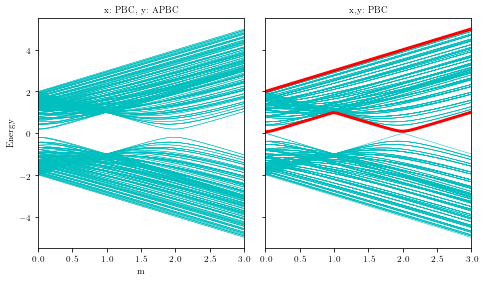

In [96]:
fig,ax=plt.subplots(1,2,sharey=True,sharex=True,tight_layout=True)
ax[0].plot(m_list,eigval_apbc_list,'c',lw=0.5)
ax[1].plot(m_list,eigval_pbc_list,'c',lw=0.5)
ax[0].set_xlabel(r'm')
ax[0].set_ylabel(r'Energy')
ax[1].plot(m_list,en_min,'r',lw=3)
ax[1].plot(m_list,en_max,'r',lw=3)
ax[0].margins(x=0)
ax[0].set_title('x: PBC, y: APBC')
ax[1].set_title('x,y: PBC')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/bs.pdf',bbox_inches='tight')

# No measurement

In [61]:
m_list=np.linspace(1,3,20)
LN_no_list=[]
MI_no_list=[]
for m in m_list:
    params=Params(m=m,Lx=32,Ly=8)
    # MI_no_list.append(params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))
    LN_no_list.append(params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)]))


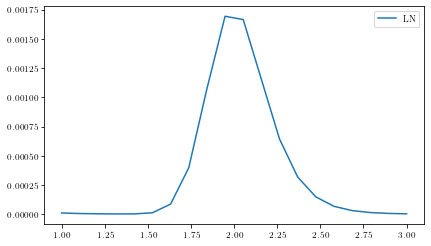

In [62]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_list,label='LN')
# ax.plot(m_list,MI_no_list,label='MI')
ax.legend()

In [54]:
params=Params(m=m,Lx=np.inf,Ly=np.inf)


In [55]:
params.covariance_matrix()

In [131]:
m_list=np.linspace(1,3,20)
LN_no_inf_list=[]
MI_no_inf_list=[]
for m in m_list:
    params=Params(m=m,Lx=np.inf,Ly=np.inf,dxmax=16,dymax=8)
    MI_no_inf_list.append(params.mutual_information_m([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))
    LN_no_inf_list.append(params.log_neg([np.arange(params.dxmax//4),np.arange(params.dymax)],[np.arange(params.dxmax//4)+params.dxmax//2,np.arange(params.dymax)]))

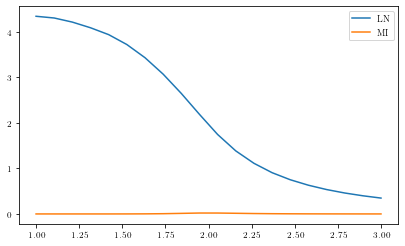

In [132]:
fig,ax=plt.subplots()
ax.plot(m_list,LN_no_inf_list,label='LN')
ax.plot(m_list,MI_no_inf_list,label='MI')
ax.legend()

# Measure to 0

In [51]:
m_list=np.linspace(1,3,20)
es=1
LN_empty_list=np.zeros((len(m_list),es))
MI_empty_list=np.zeros((len(m_list),es))
Lx,Ly=16,4
for m_i,m in enumerate(m_list):
    # st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0)
        MI_empty_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_empty_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_empty_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


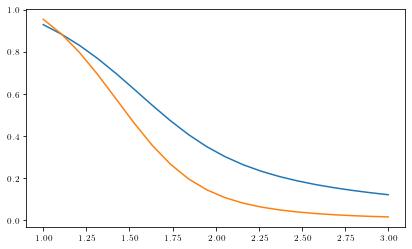

In [52]:
plt.plot(m_list,LN_empty_list)
plt.plot(m_list,MI_empty_list)

# Measure to 0.5

In [16]:
m_list=np.linspace(1,3,20)
es=50
LN_half_list=np.zeros((len(m_list),es))
MI_half_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=16,Ly=8)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],0.5)
        # MI_half_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_half_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    #  # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])],0.5).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_half_list[m_i,:]=async_result 

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:0.3


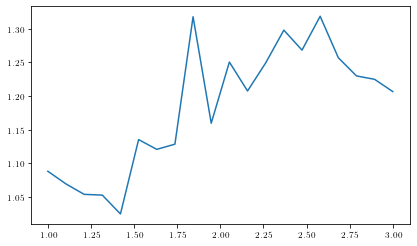

In [14]:
plt.plot(m_list,LN_half_list.mean(axis=1))
# plt.plot(m_list,LN_empty_list)

# Measure to 1

In [182]:
m_list=np.linspace(1,3,20)
es=1
LN_occ_list=np.zeros((len(m_list),es))
MI_occ_list=np.zeros((len(m_list),es))
Lx,Ly=16,8
for m_i,m in enumerate(m_list):
    st=time.time()
    # Serial
    params0=Params(m=m,Lx=Lx,Ly=Ly)
    for es_i in range(es):
        params=copy(params0)
        params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)],1)
        # MI_occ_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
        LN_occ_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # # Parallel
    # async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    # LN_occ_list[m_i,:]=async_result 

    # print('{:d}:{:.1f}'.format(m_i,time.time()-st))


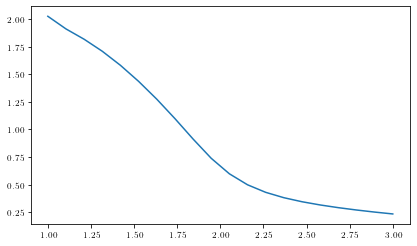

In [184]:
plt.plot(m_list,LN_occ_list)
# plt.plot(m_list,LN_empty_list)

# Born measurement

In [5]:
m_list=np.linspace(1,3,20)
es=20
LN_Born_list=np.zeros((len(m_list),es))
MI_Born_list=np.zeros((len(m_list),es))
Lx,Ly=16,16
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    LN_Born_list[m_i,:]=async_result 

    async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).mutual_information_m([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    MI_Born_list[m_i,:]=async_result

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:36.7
1:36.0
2:35.7
3:36.0
4:36.0
5:35.6
6:35.8
7:36.0
8:35.8
9:35.7
10:36.2
11:35.9
12:35.9
13:36.2
14:36.7
15:36.6
16:36.3
17:36.7
18:37.5
19:37.4


In [ ]:
es,Lx,Ly=500,32,32
with open('/mnt/d/KITP/Rp_SPT/8/MI_LN_CI_Born_En{:d}_Lx{:d}_Ly{:d}.pickle'.format(es,Lx,Ly),'rb') as f:
    [m_list,MI_Born_list,LN_Born_list,MI_no_list,LN_no_list]=pickle.load(f)

Text(0.5, 1.0, 'Ensemble Size=20, Lx=16, Ly=16')

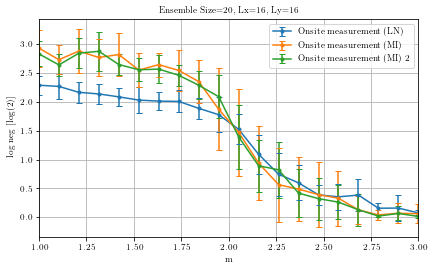

In [10]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_list,'.-',label='No measurement')

ax.errorbar(m_list,LN_Born_list.mean(axis=1)/np.log(2),LN_Born_list.std(axis=1)/np.log(2),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_list.mean(axis=1)/np.log(2),MI_Born_list.std(axis=1)/np.log(2),capsize=3,fmt='.-',label='Onsite measurement (MI)')

ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
# fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

In [7]:
m_list=np.linspace(1,3,20)
es=20
LN_Born_inf_list=np.zeros((len(m_list),es))
MI_Born_inf_list=np.zeros((len(m_list),es))
Lx,Ly=16,16
for m_i,m in enumerate(m_list):
    st=time.time()
    # # Serial
    # params0=Params(m=m,Lx=Lx,Ly=Ly)
    # for es_i in range(es):
    #     params=copy(params0)
    #     params.measure_all_Born([np.arange(params.Lx//4,params.Lx//2),np.arange(params.Ly)])
    #     # MI_Born_inf_list[m_i,es_i]=params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])
    #     LN_Born_inf_list[m_i,es_i]=params.log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

    # Parallel
    async_result=rc[:].map_sync((lambda p:Params(m=p[0],dxmax=p[1],dymax=p[2],Lx=np.inf,Ly=np.inf).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).log_neg([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    LN_Born_inf_list[m_i,:]=async_result 

    async_result=rc[:].map_sync((lambda p:Params(m=p[0],Lx=p[1],Ly=p[2]).measure_all_Born([np.arange(p[1]//4,p[1]//2),np.arange(p[2])]).mutual_information_m([np.arange(p[1]//4),np.arange(p[2])],[np.arange(p[1]//4)+p[1]//2,np.arange(p[2])])),[(m,Lx,Ly) for _ in range(es)])
    MI_Born_inf_list[m_i,:]=async_result

    print('{:d}:{:.1f}'.format(m_i,time.time()-st))


0:39.4
1:38.8
2:38.7
3:38.8
4:38.2
5:37.9
6:38.8
7:38.3
8:38.1
9:38.0
10:38.0
11:38.1
12:38.4
13:38.2
14:38.3
15:38.7
16:38.4
17:38.7
18:38.8
19:38.4


Text(0.5, 1.0, 'Ensemble Size=20, Lx=16, Ly=16')

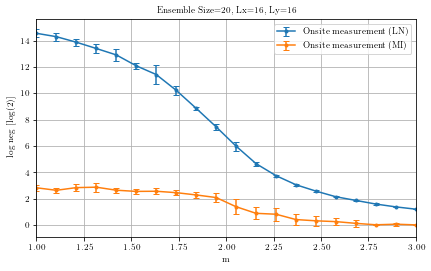

In [11]:
fig,ax=plt.subplots()
# ax.plot(m_list,LN_no_inf_list,'.-',label='No measurement (LN)')
# ax.plot(m_list,MI_no_inf_list,'.-',label='No measurement (MI)')

ax.errorbar(m_list,LN_Born_inf_list.mean(axis=1)/np.log(2),LN_Born_inf_list.std(axis=1),capsize=3,fmt='.-',label='Onsite measurement (LN)')
ax.errorbar(m_list,MI_Born_inf_list.mean(axis=1)/np.log(2),MI_Born_inf_list.std(axis=1),capsize=3,fmt='.-',label='Onsite measurement (MI)')
ax.legend()
ax.grid('on')
ax.set_xlabel(r'm')
ax.set_ylabel(r'log neg [log(2)]')
ax.margins(x=0)
ax.set_title('Ensemble Size={:d}, Lx={:d}, Ly={:d}'.format(es,Lx,Ly))
# fig.savefig('/mnt/d/KITP/Rp_SPT/8/LN_CI_Born_inf_En{:d}_Lx{:d}_Ly{:d}.pdf'.format(es,Lx,Ly),bbox_inches='tight')

# Scaling at m=2

## no measurement

In [1]:
import matplotlib.patches as mpatches
def place_region(x,y,fig,ax,color='ybyk'):  
    # fig,ax=plt.subplots()
    arc=[mpatches.Arc((x,y),50,50,-theta,0,90,transform=None,ec=ec,lw=5) for theta,ec in zip(np.arange(4)*90,color)]
    [fig.artists.append(arc) for arc in arc]
    ax.text(x+25,y+25,r'$A$',transform=None,ha='center',va='center')
    ax.text(x+25,y-25,r'$A^\prime$',transform=None,ha='center',va='center')
    ax.text(x-25,y-25,r'$B$',transform=None,ha='center',va='center')
    ax.text(x-25,y+25,r'$B^\prime$',transform=None,ha='center',va='center')

In [ ]:
eta_no_list=[]
MI_no_list=[]
LN_no_list=[]
x_list=[]
L=32
params=Params(m=2,Lx=L,Ly=16)
for ii in range(500):
    print(ii)
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    while x in x_list:
        x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
        x=[0]+x
    x_list.append(x)
    eta=cross_ratio(x,L)
    eta_no_list.append(eta)
    subregionA=[np.arange(x[0],x[1]),np.arange(params.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params.Ly)]
    MI=params.mutual_information_m(subregionA,subregionB)    
    MI_no_list.append(MI)
    LN=params.log_neg(subregionA,subregionB)
    LN_no_list.append(LN)
eta_no_list=np.array(eta_no_list)
MI_no_list=np.array(MI_no_list)
LN_no_list=np.array(LN_no_list)

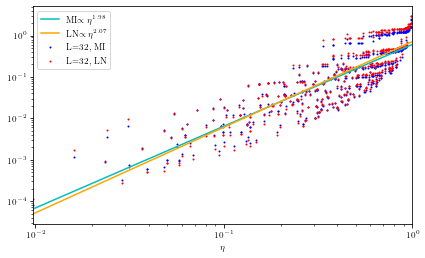

In [113]:
fig,ax=plt.subplots()
ax.scatter(eta_no_list,MI_no_list,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_no_list,LN_no_list,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_no_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_no_list>1e-10)&((eta_no_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_no_list[mask_MI]),np.log(MI_no_list[mask_MI]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_no_list>1e-10)&((eta_no_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_no_list[mask_LN]),np.log(LN_no_list[mask_LN]))
x_int=np.linspace(np.min(eta_no_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ykyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_no.pdf')

# Born measurement

In [ ]:
eta_Born_onsite_Ap_list=[]
MI_Born_onsite_Ap_list=[]
LN_Born_onsite_Ap_list=[]
# x_list=[]
# subregion_list=[]
es=50
L=16
params_init=Params(m=2,Lx=L,Ly=8)

for _ in range(200):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=[np.arange(x[0],x[1]),np.arange(params_init.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params_init.Ly)]
    subregionAp=[np.arange(x[1],x[2]),np.arange(params_init.Ly)]
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_Ap_list.append(eta)
    MI_Born_onsite_Ap_list.append(MI_ensemble_list)
    LN_Born_onsite_Ap_list.append(LN_ensemble_list)
eta_Born_onsite_Ap_list=np.array(eta_Born_onsite_Ap_list)
MI_Born_onsite_Ap_list=np.array(MI_Born_onsite_Ap_list)
LN_Born_onsite_Ap_list=np.array(LN_Born_onsite_Ap_list)

In [97]:
with open('/mnt/d/kitp/Rp_SPT/8/MI_LN_CI_Born_En100_pts200_Lx32_Ly16_Ap.pickle','rb') as f:
    [eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list]=pickle.load(f)

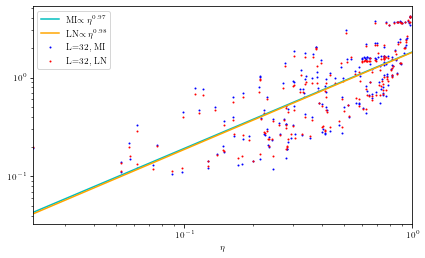

In [100]:
MI_Born_onsite_Ap_list_mean=MI_Born_onsite_Ap_list.mean(axis=1)
LN_Born_onsite_Ap_list_mean=LN_Born_onsite_Ap_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list_mean,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_Born_onsite_Ap_list,LN_Born_onsite_Ap_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_Ap_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_MI]),np.log(MI_Born_onsite_Ap_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_Ap_list_mean>1e-10)&((eta_Born_onsite_Ap_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_Ap_list[mask_LN]),np.log(LN_Born_onsite_Ap_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_Ap_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ycyk')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_Born_onsite_Ap.pdf')


In [10]:
eta_Born_onsite_ApBp_list=[]
MI_Born_onsite_ApBp_list=[]
LN_Born_onsite_ApBp_list=[]
# x_list=[]
# subregion_list=[]
es=50
L=32
params_init=Params(m=2,Lx=L,Ly=8)

for _ in range(200):
    MI_ensemble_list=[]
    LN_ensemble_list=[]
    x=sorted(np.random.choice(np.arange(1,L),3,replace=False))
    x=[0]+x
    subregionA=[np.arange(x[0],x[1]),np.arange(params_init.Ly)]
    subregionB=[np.arange(x[2],x[3]),np.arange(params_init.Ly)]
    subregionAp=[np.arange(x[1],x[2]),np.arange(params_init.Ly)]
    subregionBp=[np.arange(x[3],L),np.arange(params_init.Ly)]
    eta=cross_ratio(x,L)
    for _ in range(es):
        params=copy(params_init)
        params.measure_all_Born(subregionAp)
        MI_ensemble_list.append(params.mutual_information_m(subregionA,subregionB))
        LN_ensemble_list.append(params.log_neg(subregionA,subregionB))

    eta_Born_onsite_ApBp_list.append(eta)
    MI_Born_onsite_ApBp_list.append(MI_ensemble_list)
    LN_Born_onsite_ApBp_list.append(LN_ensemble_list)
eta_Born_onsite_ApBp_list=np.array(eta_Born_onsite_ApBp_list)
MI_Born_onsite_ApBp_list=np.array(MI_Born_onsite_ApBp_list)
LN_Born_onsite_ApBp_list=np.array(LN_Born_onsite_ApBp_list)

In [114]:
with open('/mnt/d/kitp/Rp_SPT/8/MI_LN_CI_Born_En100_pts200_Lx32_Ly16_ApBp.pickle','rb') as f:
    [eta_Born_onsite_Ap_list,MI_Born_onsite_Ap_list,LN_Born_onsite_Ap_list]=pickle.load(f)

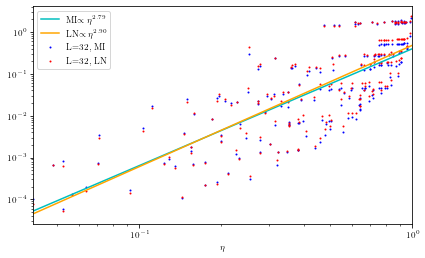

In [116]:
MI_Born_onsite_ApBp_list_mean=MI_Born_onsite_ApBp_list.mean(axis=1)
LN_Born_onsite_ApBp_list_mean=LN_Born_onsite_ApBp_list.mean(axis=1)
fig,ax=plt.subplots()
ax.scatter(eta_Born_onsite_ApBp_list,MI_Born_onsite_ApBp_list_mean,s=1,color='b',label='L={:d}, MI'.format(L))
ax.scatter(eta_Born_onsite_ApBp_list,LN_Born_onsite_ApBp_list_mean,s=1,color='r',label='L={:d}, LN'.format(L))

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlim([np.min(eta_Born_onsite_ApBp_list),1])
# ax.set_ylim([1e-10,1])

mask_MI=(MI_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<1)
lr_MI=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_MI]),np.log(MI_Born_onsite_ApBp_list_mean[mask_MI]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_MI.slope*np.log(x_int)+lr_MI.intercept)
ax.plot(x_int,y_int,'c',label=r'MI$\propto\eta^{{{:.2f}}}$'.format(lr_MI.slope))

mask_LN=(LN_Born_onsite_ApBp_list_mean>1e-10)&((eta_Born_onsite_ApBp_list)<1)
lr_LN=scipy.stats.linregress(np.log(eta_Born_onsite_ApBp_list[mask_LN]),np.log(LN_Born_onsite_ApBp_list_mean[mask_LN]))
x_int=np.linspace(np.min(eta_Born_onsite_ApBp_list),1,10)
y_int=np.exp(lr_LN.slope*np.log(x_int)+lr_LN.intercept)
ax.plot(x_int,y_int,label=r'LN$\propto\eta^{{{:.2f}}}$'.format(lr_LN.slope),color='orange')
ax.set_xlabel(r'$\eta$')
ax.legend()

# place_region(200,200,fig,ax,'ycyc')
fig.savefig('/mnt/d/kitp/Rp_SPT/8/MI_LN_Born_onsite_ApBp.pdf')


# Check area law of EE

In [72]:
EE_list={}

In [74]:
l_EE_list=np.arange(2,32)
for Ly in (8,12,16):
    params=Params(m=1,Lx=32,Ly=Ly)
    EE_list[Ly]=[(params.von_Neumann_entropy_f([np.arange(l),np.arange(params.Ly)])) for l in l_EE_list]


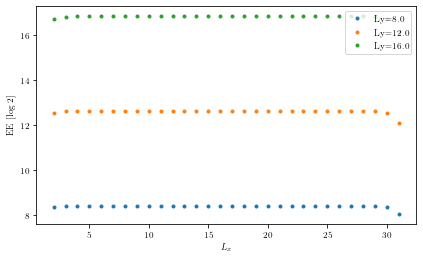

In [75]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

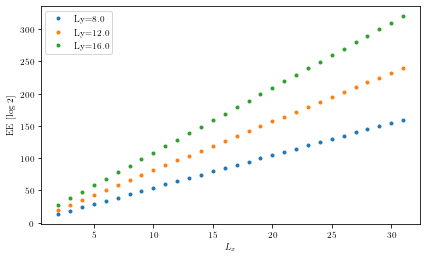

In [ ]:
fig,ax=plt.subplots()
for Ly in (8,12,16):
    ax.plot(l_EE_list,EE_list[Ly]/np.log(2),'.',label='Ly={:.1f}'.format(Ly))
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('EE [log 2]')
ax.legend()

# LN scaling behavior

In [25]:
LN_scaling_list={}

In [55]:
Ly_list=np.arange(2,16)
Lx_list=np.arange(2,8)
LN_scaling_list=np.zeros((Lx_list.shape[0],Ly_list.shape[0]))
for Ly_i,Ly in enumerate(Ly_list):
    for Lx_i,Lx in enumerate(Lx_list):
        params=Params(m=1,Lx=4*Lx,Ly=Ly)
        LN_scaling_list[Lx_i,Ly_i]=params.log_neg([np.arange(Lx),np.arange(Ly)],[np.arange(Lx)+2*Lx,np.arange(Ly)])


In [56]:
Lx_map,Ly_map=np.meshgrid(Lx_list,Ly_list)

In [ ]:
plt.plot()

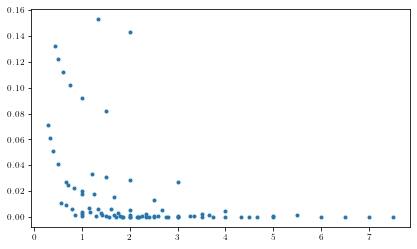

In [57]:
plt.plot((Ly_map/Lx_map).flatten(),LN_scaling_list.flatten(),'.')

Text(0, 0.5, 'log neg')

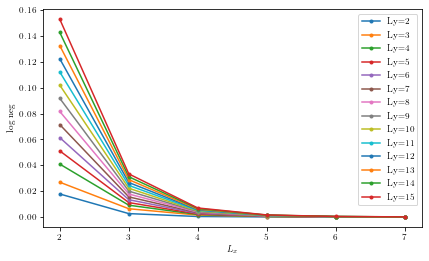

In [121]:
fig,ax=plt.subplots()
for Ly_i,Ly in enumerate(Ly_list):
    ax.plot(Lx_list,LN_scaling_list[:,Ly_i],'.-',label='Ly={:d}'.format(Ly))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$L_x$')
ax.set_ylabel('log neg')

Text(0, 0.5, 'log neg')

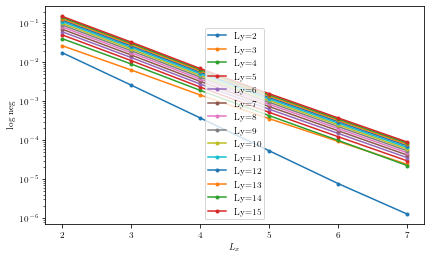

In [122]:
fig,ax=plt.subplots()
for Ly_i,Ly in enumerate(Ly_list):
    ax.plot(Lx_list,LN_scaling_list[:,Ly_i],'.-',label='Ly={:d}'.format(Ly))
ax.set_yscale('log')
# ax.set_xscale('log')
ax.legend()
ax.set_xlabel('$L_x$')
ax.set_ylabel('log neg')

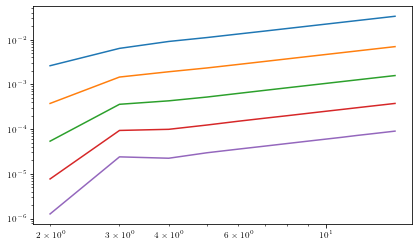

In [71]:
fig,ax=plt.subplots()
ax.plot(Ly_list,LN_scaling_list[1,:])
ax.plot(Ly_list,LN_scaling_list[2,:])
ax.plot(Ly_list,LN_scaling_list[3,:])
ax.plot(Ly_list,LN_scaling_list[4,:])
ax.plot(Ly_list,LN_scaling_list[5,:])
ax.set_yscale('log')
ax.set_xscale('log')

In [69]:
l_LN_list=np.arange(2,8)
for Ly in (8,12,16):
    LN_scaling_list[Ly]=[]
    for Lx in l_LN_list:
        params=Params(m=1,Lx=4*Lx,Ly=Ly)
        LN_scaling_list[Ly].append(params.log_neg([np.arange(Lx),np.arange(params.Ly)],[np.arange(Lx)+2*Lx,np.arange(params.Ly)]))

Text(0, 0.5, 'Log neg [log 2]')

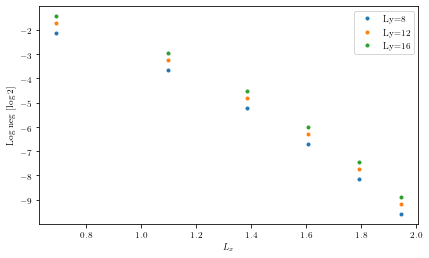

In [75]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(np.log(l_LN_list),np.log(v/np.log(2)),'.',label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

In [80]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

Text(0, 0.5, 'Log neg [log 2]')

Text(0, 0.5, 'Log neg [log 2]')

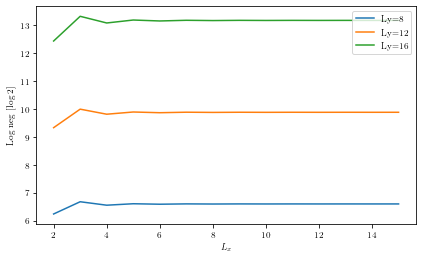

In [95]:
fig,ax=plt.subplots()
for k,v in LN_scaling_list.items():
    ax.plot(l_LN_list,v/np.log(2),label='Ly={}'.format(k))
ax.legend()
ax.set_xlabel(r'$L_x$')
ax.set_ylabel('Log neg [log 2]')

# profiler

In [22]:
params=Params(Lx=32,Ly=16,history=False)

In [33]:
def test(A):
    return A+A.T

In [34]:
z=np.random.rand(2048,2048)

In [35]:
%lprun -f test test(z)

Timer unit: 1e-06 s

Total time: 0.072097 s
File: <ipython-input-33-b33413829b27>
Function: test at line 1

Line #      Hits         Time  Per Hit   % Time  Line Contents
     1                                           def test(A):
     2         1      72097.0  72097.0    100.0      return A+A.T

In [37]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-36-933e8321812b>
Function: measure at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def measure(self, s, ix):
   264                                                   if not hasattr(self, 'C_m'):
   265                                                       self.covariance_matrix()
   266                                                   if not hasattr(self, 's_history'):
   267                                                       self.s_history = []
   268                                                   if not hasattr(self, 'i_history'):
   269                                                       self.i_history = []
   270                                           
   271                                                   mat = self.C_m_history[-1].copy()
   272                                           
   273                                     

In [23]:
%lprun -f Params.measure params.measure_all_Born([np.arange(params.Lx//4)+params.Lx//4,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 29.93 s
File: <ipython-input-20-6f8c91c52c07>
Function: measure at line 263

Line #      Hits         Time  Per Hit   % Time  Line Contents
   263                                               def measure(self, s, ix):
   264       256       1244.0      4.9      0.0          if not hasattr(self, 'C_m'):
   265                                                       self.covariance_matrix()
   266       256        532.0      2.1      0.0          if not hasattr(self, 's_history'):
   267         1          1.0      1.0      0.0              self.s_history = []
   268       256        510.0      2.0      0.0          if not hasattr(self, 'i_history'):
   269         1          1.0      1.0      0.0              self.i_history = []
   270                                           
   271       256    2002997.0   7824.2      6.7          mat = self.C_m_history[-1].copy()
   272                                           
   273       768       4359.0      5.7 

In [12]:
%lprun -f Params.bandstructure params.covariance_matrix()

Timer unit: 1e-06 s

Total time: 0 s
File: <ipython-input-9-f4caf49fbcb7>
Function: bandstructure at line 40

Line #      Hits         Time  Per Hit   % Time  Line Contents
    40                                               def bandstructure(self):
    41                                                   val, vec = nla.eigh(self.Hamiltonian)
    42                                                   sortindex = np.argsort(val)
    43                                                   self.val = val[sortindex]
    44                                                   self.vec = vec[:, sortindex]

In [343]:
%lprun -f Params.c_subregion_m params.c_subregion_m([np.arange(params.Lx//4),np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.094403 s
File: <ipython-input-310-09246d8612a9>
Function: c_subregion_m at line 146

Line #      Hits         Time  Per Hit   % Time  Line Contents
   146                                               def c_subregion_m(self, subregion, Gamma=None):
   147                                                   '''
   148                                                   subregion: [subregoin_x, subregion_y] index of unit cell
   149                                                   '''
   150         1          2.0      2.0      0.0          if not hasattr(self, 'C_m'):
   151         1      93460.0  93460.0     99.0              self.covariance_matrix()
   152         1          3.0      3.0      0.0          if Gamma is None:
   153         1          2.0      2.0      0.0              Gamma = self.C_m_history[-1]
   154         1          1.0      1.0      0.0          try:
   155         1          5.0      5.0      0.0              subregion = list(sub

In [334]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4),np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.11278 s
File: <ipython-input-310-09246d8612a9>
Function: von_Neumann_entropy_m at line 183

Line #      Hits         Time  Per Hit   % Time  Line Contents
   183                                               def von_Neumann_entropy_m(self, subregion):
   184         1     107655.0 107655.0     95.5          c_A = self.c_subregion_m(subregion)
   185         1       4908.0   4908.0      4.4          val = nla.eigvalsh(1j*c_A)
   186         1          4.0      4.0      0.0          self.val_sh = val
   187         1         41.0     41.0      0.0          val = np.sort(val)
   188         1         31.0     31.0      0.0          val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
   189         1        141.0    141.0      0.1          return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

In [335]:
%lprun -f Params.von_Neumann_entropy_m Params(Lx=16,Ly=16).von_Neumann_entropy_m([np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.094029 s
File: <ipython-input-310-09246d8612a9>
Function: von_Neumann_entropy_m at line 183

Line #      Hits         Time  Per Hit   % Time  Line Contents
   183                                               def von_Neumann_entropy_m(self, subregion):
   184         1      88525.0  88525.0     94.1          c_A = self.c_subregion_m(subregion)
   185         1       5259.0   5259.0      5.6          val = nla.eigvalsh(1j*c_A)
   186         1          3.0      3.0      0.0          self.val_sh = val
   187         1         37.0     37.0      0.0          val = np.sort(val)
   188         1         47.0     47.0      0.0          val = (1-val)/2+1e-18j  # \lambda=(1-\xi)/2
   189         1        158.0    158.0      0.2          return np.real(-np.sum(val*np.log(val))-np.sum((1-val)*np.log(1-val)))/2

In [340]:
%lprun -f Params.mutual_information_m params.mutual_information_m([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.037132 s
File: <ipython-input-310-09246d8612a9>
Function: mutual_information_m at line 202

Line #      Hits         Time  Per Hit   % Time  Line Contents
   202                                               def mutual_information_m(self, subregion_A, subregion_B):
   203         1        686.0    686.0      1.8          subregion_A=self.linearize_index(subregion_A,4)
   204         1        407.0    407.0      1.1          subregion_B=self.linearize_index(subregion_B,4)
   205         3        578.0    192.7      1.6          assert np.intersect1d(
   206         2          2.0      1.0      0.0              subregion_A, subregion_B).size == 0, "Subregion A and B overlap"
   207         1       5964.0   5964.0     16.1          s_A = self.von_Neumann_entropy_m(subregion_A)
   208         1       5543.0   5543.0     14.9          s_B = self.von_Neumann_entropy_m(subregion_B)
   209         1        147.0    147.0      0.4          subregion_AB=np.conc

In [331]:
%lprun -f Params.log_neg Params(m=m,Lx=16,Ly=16).log_neg([np.arange(params.Lx//4),np.arange(params.Ly)],[np.arange(params.Lx//4)+params.Lx//2,np.arange(params.Ly)])

Timer unit: 1e-06 s

Total time: 0.202006 s
File: <ipython-input-310-09246d8612a9>
Function: log_neg at line 213

Line #      Hits         Time  Per Hit   % Time  Line Contents
   213                                               def log_neg(self,subregion_A,subregion_B,Gamma=None):
   214         1        333.0    333.0      0.2          subregion_A=self.linearize_index(subregion_A,4)
   215         1        155.0    155.0      0.1          subregion_B=self.linearize_index(subregion_B,4)
   216         1        155.0    155.0      0.1          assert np.intersect1d(subregion_A,subregion_B).size==0 , "Subregion A and B overlap"
   217         1          2.0      2.0      0.0          if not hasattr(self,'C_m'):
   218         1      87192.0  87192.0     43.2              self.covariance_matrix()
   219                                                   
   220         1          3.0      3.0      0.0          if Gamma is None:
   221         1          3.0      3.0      0.0             

In [ ]:
# Check scaling behavior